Check Data Distribution: Ensure the dataset is balanced among the categories. A skewed distribution can cause the model to predict the most frequent class.
Increase Dropout: To help with overfitting, especially given your issue with converging on a single class.
Modify the Transformer Setup: Adjust parameters like the number of heads and layers, especially if your model complexity doesn't match the task complexity.
Learning Rate Scheduler: Implement a scheduler to adjust the learning rate during training, which can help in better convergence.
Model Regularization: Consider adding batch normalization layers to stabilize the learning process.
Increase Epochs: As suggested by your TA, increasing the number of training epochs might help, but first ensure that the model architecture and learning rate are optimally set.

In [5]:
from socket import gethostname
gethostname()

'hpc3-gpu-24-01'

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model and move it to device
class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.output_layer = nn.Linear(64*12*12, 7)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 64*12*12)
        x = self.output_layer(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
model = FERModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc.append(correct / total)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_acc.append(correct / total)


    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {train_acc[-1]}, Val Acc: {val_acc[-1]}')


Using device: cuda


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:35<00:00, 25.37it/s]


Epoch 1, Train Loss: 1.727391247523608, Val Loss: 1.4477039232131796, Train Acc: 0.3684210526315789, Val Acc: 0.4480356645305099


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 26.08it/s]


Epoch 2, Train Loss: 1.373020894249063, Val Loss: 1.34394962817854, Train Acc: 0.48089449301612736, Val Acc: 0.4845360824742268


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:35<00:00, 25.37it/s]


Epoch 3, Train Loss: 1.2791326619426993, Val Loss: 1.2986601447620643, Train Acc: 0.5167020794872688, Val Acc: 0.5073836723321259


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 26.32it/s]


Epoch 4, Train Loss: 1.208776701305963, Val Loss: 1.2744585685525376, Train Acc: 0.5480859660733568, Val Acc: 0.514349400947339


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:33<00:00, 26.52it/s]


Epoch 5, Train Loss: 1.1464483934226275, Val Loss: 1.2656978314286256, Train Acc: 0.5741056811452855, Val Acc: 0.5241014210086375


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:46<00:00, 19.48it/s]


Epoch 6, Train Loss: 1.0910579112551961, Val Loss: 1.244882859370608, Train Acc: 0.5952837089414469, Val Acc: 0.5358038450821956


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:44<00:00, 20.31it/s]


Epoch 7, Train Loss: 1.0404195939573966, Val Loss: 1.2384586750248674, Train Acc: 0.6108885715280923, Val Acc: 0.5405405405405406


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:41<00:00, 21.64it/s]


Epoch 8, Train Loss: 0.9866593920153516, Val Loss: 1.2812968441688706, Train Acc: 0.6384409070326379, Val Acc: 0.5286988018946782


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:34<00:00, 25.98it/s]


Epoch 9, Train Loss: 0.9454858218404026, Val Loss: 1.238707861833235, Train Acc: 0.649935560277265, Val Acc: 0.5484814711618835


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:33<00:00, 26.83it/s]


Epoch 10, Train Loss: 0.9069781048597929, Val Loss: 1.245927945954383, Train Acc: 0.6700337873140827, Val Acc: 0.546113123432711


In [8]:
print(model)

FERModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.25, inplace=False)
  )
  (output_layer): Linear(in_features=9216, out_features=7, bias=True)
)


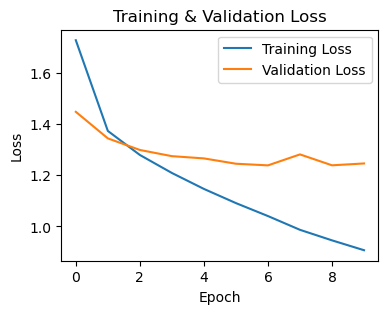

In [16]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
print(train_losses)
print(val_losses)

[1.727391247523608, 1.373020894249063, 1.2791326619426993, 1.208776701305963, 1.1464483934226275, 1.0910579112551961, 1.0404195939573966, 0.9866593920153516, 0.9454858218404026, 0.9069781048597929]
[1.4477039232131796, 1.34394962817854, 1.2986601447620643, 1.2744585685525376, 1.2656978314286256, 1.244882859370608, 1.2384586750248674, 1.2812968441688706, 1.238707861833235, 1.245927945954383]


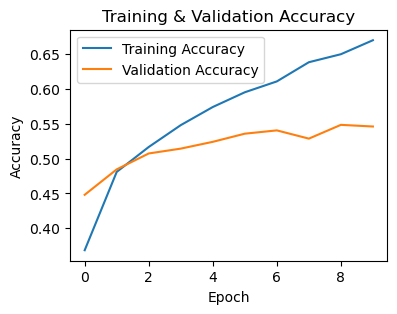

In [17]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_loader is your DataLoader for the test dataset
true_labels = []
predicted_labels = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {overall_accuracy:.2f}')


Overall Accuracy: 0.55


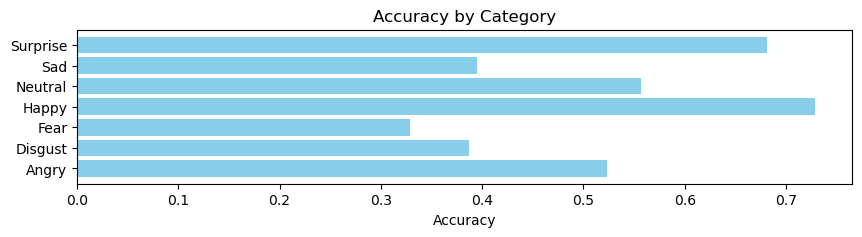

In [13]:
import numpy as np

category_accuracies = []
for i in range(7):
    category_mask = (np.array(true_labels) == i)
    category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
    category_accuracies.append(category_acc)

# Plotting category accuracies
categories = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
ax.barh(range(7), category_accuracies, color='skyblue')
ax.set_xlabel('Accuracy')
ax.set_yticks(range(7))
ax.set_yticklabels(categories)
ax.set_title('Accuracy by Category')
plt.show()

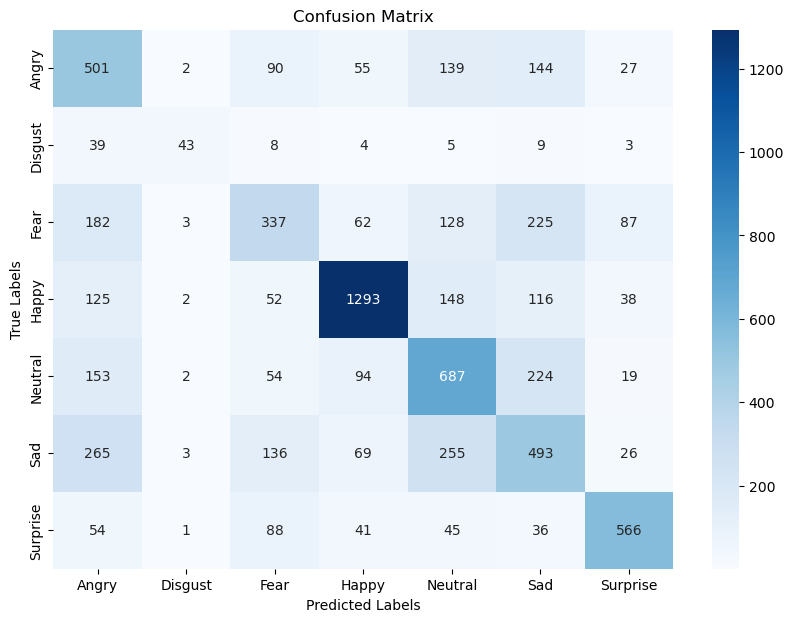

In [14]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
